In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings
from sklearn import model_selection
from torchvision import datasets
from torchvision import transforms
from sklearn.model_selection import train_test_split, learning_curve,ShuffleSplit
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator
from collections import Counter
from numpy.random import beta

data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

def get_data(data, indices=None, binarize=True):
  N = len(data)
  if indices is None:
    indices = range(0, N)
  #X = torch.stack([data[i][0] for i in indices], dim=1).squeeze(0) # (N,28,28)
  X = np.stack([data[i][0].numpy() for i in indices], axis=1).squeeze(0) # (N,28,28)
  if binarize: X = (X > 0.5)
  #y = torch.tensor([data[i][1] for i in indices])
  y = np.array([data[i][1] for i in indices])
  return X, y

data = datasets.EMNIST(
    root="~/data",
    split="balanced",
    download=True, transform=data_transform
)

X, y = get_data(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=0)
	


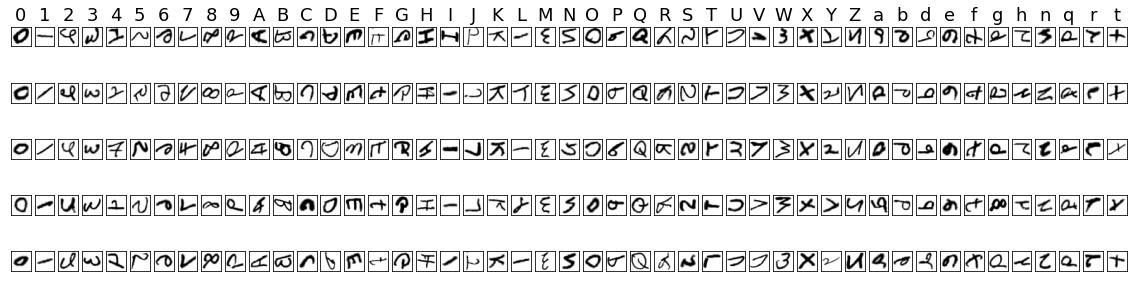

In [ ]:
fig = plt.figure(figsize=(20, 5))
r,c = 5, len(data.classes)
for i in range(c):
  img_idx = [k for k in range(len(y)) if y[k] == i]
  smp_img = random.sample(img_idx,5)
  for j in range(r):
    idx = smp_img[j]
    img, label = data[idx]
    fig.add_subplot(r, c, c*j + (i+1))
    label = data.classes[label]
    if j ==0:
      plt.title(label, fontsize=18)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.squeeze(), cmap=plt.cm.binary)
# plt.tight_layout()
plt.show()

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  if axes is None:
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
  axes[0].set_title(title)
  if ylim is not None:
    axes[0].set_ylim(*ylim)
  axes[0].set_xlabel("Training examples")
  axes[0].set_ylabel("Score")
  train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  fit_times_mean = np.mean(fit_times, axis=1)
  fit_times_std = np.std(fit_times, axis=1)
# Plot learning curve
  axes[0].grid()
  axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
  train_scores_mean + train_scores_std, alpha=0.1,
  color="r")
  axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
  test_scores_mean + test_scores_std, alpha=0.1,
  color="g")
  axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
  label="Training score")
  axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
  label="Cross-validation score")
  axes[0].legend(loc="best")
  # Plot n_samples vs fit_times
  axes[1].grid()
  axes[1].plot(train_sizes, fit_times_mean, 'o-')
  axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
  fit_times_mean + fit_times_std, alpha=0.1)
  axes[1].set_xlabel("Training examples")
  axes[1].set_ylabel("fit_times")
  axes[1].set_title("Scalability of the model")
  return plt

In [ ]:
def accuracy(preds, actuals):
  return sum(pred == actual for pred, actual in zip(preds, actuals)) / len(actuals)

In [ ]:
class MLE(BaseEstimator):
  def __init__(self, typeOflbls=47):
    self.typeOflbls = typeOflbls
    self.pb = []
    self.clsPrio = []

  def fit(self, X, y):
    for class_ in range(self.typeOflbls):
      class_indices = (y == class_)
      yCls = y[class_indices]
      xCls = X[class_indices]
      xCls = xCls.reshape(xCls.shape[0], -1)
      mus_class = np.mean(xCls, axis=0)
      self.pb.append(mus_class)
    counts = Counter(y)
    self.clsPrio = [counts[i]/len(y) for i in range(self.typeOflbls)]

  def predict_proba(self, X):
    X = X.reshape(X.shape[0], -1)
    lh = []
    for _ in range(len(X)):
      lh.append([])
    for clss in range(self.typeOflbls):
      mus = self.pb[clss]
      for i in range(len(X)):
        image = X[i]
        score = 0
        for j, pixel in enumerate(image):
          score += np.log(mus[j] + 1e-10) if pixel else np.log(1 - mus[j] + 1e-10)
        lh[i].append(score + np.log(self.clsPrio[clss]))
      lh = np.array(lh)
      return lh

  def predict(self, X):
    return self.predict_proba(X).argmax(axis=1)

  def __get_prob(self, image, mus, clss):
    return sum(np.log(mus[i] if image[i] == 1 else (1 - mus[i]) + 1e-10) for i in range(len(image))) + np.log(self.clsPrio[clss])

  def score(self, X, y, epsilon=1e-12):
    ce = 0
    X = X.reshape(X.shape[0], -1)
    for i, clss in enumerate(y):
      mus = self.pb[clss]
      ce += self.__get_prob(X[i], mus, clss)
    return ce / X.shape[0]

In [ ]:
class MAP(BaseEstimator):
  def __init__(self, alphas, betas, typeOflbls=47):
    self.typeOflbls = typeOflbls
    self.pb = []
    self.alphas = alphas
    self.betas = betas
    self.clsPrio = []
    self.num_ones = []
    self.__class_dist = []

  def mode(self, class_, alphas):
    return (alphas[class_] - 1) / (sum(alphas) - self.typeOflbls)

  def fit(self, X, y):
    for clss in range(self.typeOflbls):
      clssIndices = (y == clss)
      yCls = y[clssIndices]
      xCls = X[clssIndices]
      xCls = xCls.reshape(xCls.shape[0], -1)
      ones = np.sum(xCls, axis=0)
      self.num_ones.append((ones, len(xCls)))
    counts = Counter(y)
    self.__class_dist = [counts[i]/len(y) for i in range(self.typeOflbls)]
    self.generate_mus()
    new_alphas = self.generate_alphas()
    self.clsPrio = [self.mode(clss, new_alphas) for clss in range(self.typeOflbls)]

  def generate_alphas(self, alphas=None):
    if alphas is None:
      alphas = self.alphas
    return [a + b for a, b in zip(self.alphas, self.__class_dist)]

  def generate_mus(self):
    a, b = self.betas
    for clss in range(self.typeOflbls):
      ones, total = self.num_ones[clss]
      n = total - ones
      m = ones + a
      n = n + b
      self.pb.append((m - 1)/(m + n - 2))
    
  def predict_proba(self, X):
    X = X.reshape(X.shape[0], -1)
    posteriors = []
    for _ in range(len(X)):
      posteriors.append([])
    for clss in range(self.typeOflbls):
      mus = self.pb[clss]
      for i in range(len(X)):
        image = X[i]
        score = 0
        for j, pixel in enumerate(image):
          score += np.log(mus[j] + 1e-10) if pixel else np.log(1 - mus[j] + 1e-10)
        posteriors[i].append(score + np.log(self.clsPrio[clss]))
    posteriors = np.array(posteriors)
    return posteriors

  def predict(self, X):
    return self.predict_proba(X).argmax(axis=1)

  def __get_prob(self, image, mus, clss):
    total = 0
    for i, pixel in enumerate(image):
      total += np.log(mus[i] if image[i] == 1 else (1 - mus[i]) + 1e-10)
    return total + np.log(self.clsPrio[clss])

  def score(self, X, y, epsilon=1e-12):
    ce = 0
    X = X.reshape(X.shape[0], -1)
    for i, clss in enumerate(y):
      mus = self.pb[clss]
      ce += self.__get_prob(X[i], mus, clss)
    return ce / X.shape[0]


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

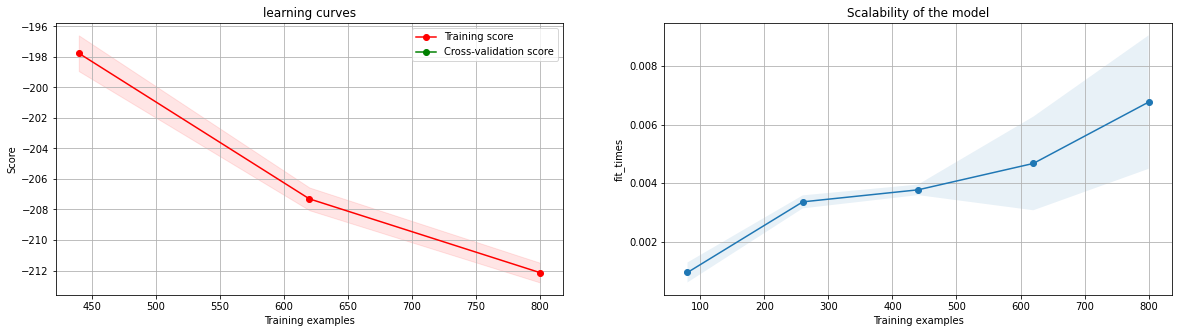

In [ ]:
mle = MLE()
plot_learning_curve(MLE(), 'learning curves', X_train[:1000], y_train[:1000], n_jobs=-1)

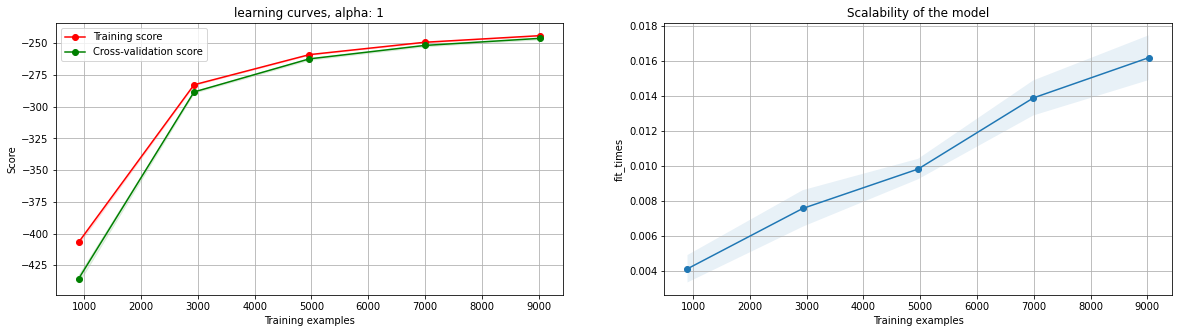

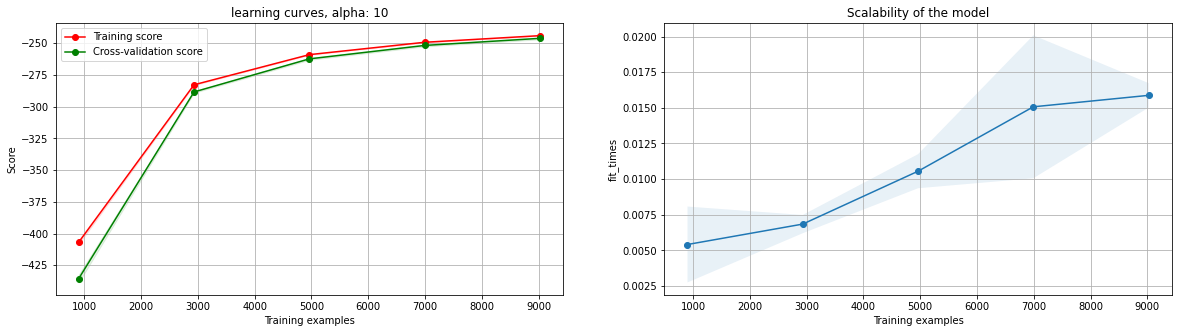

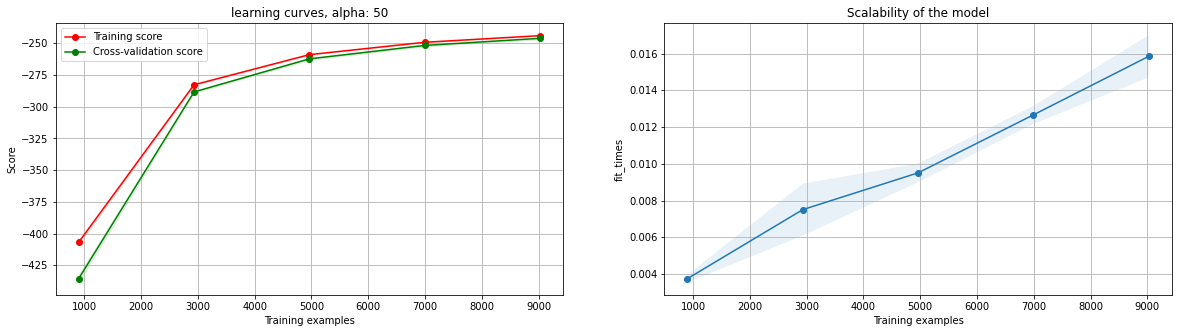

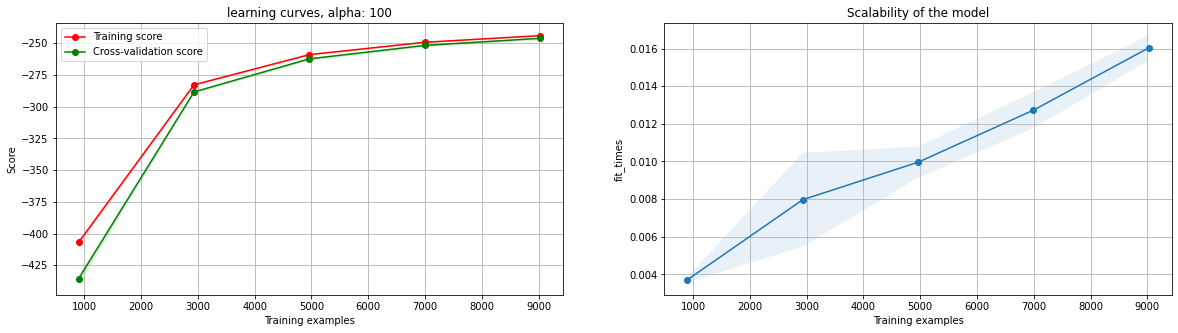

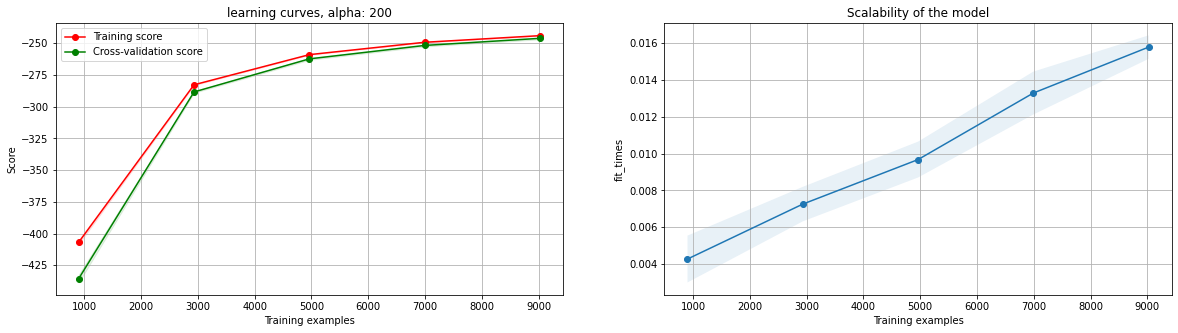

In [ ]:
map_ = MAP(alphas=[1] * 47, betas=[10, 10])
for alpha in (1,10,50,100,200):
  map_ = MAP(alphas=[alpha] * 47, betas=[10, 1])
  plt = plot_learning_curve(map_, f'learning curves, alpha: {alpha}', X_train, y_train, n_jobs=-1)
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


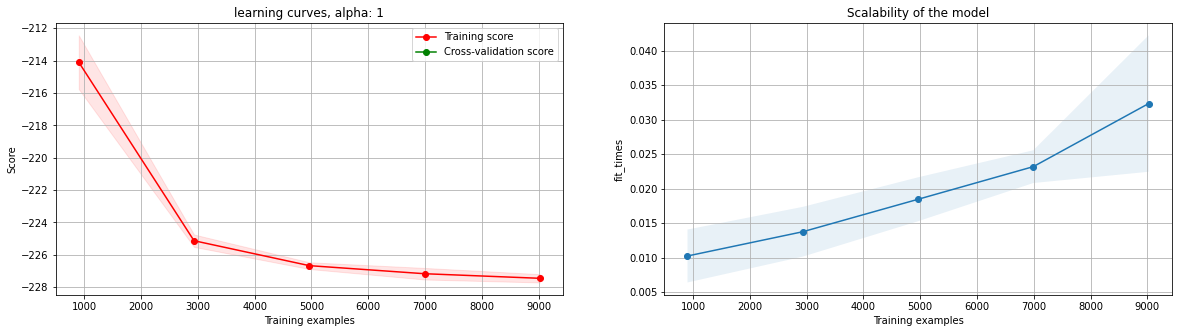

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


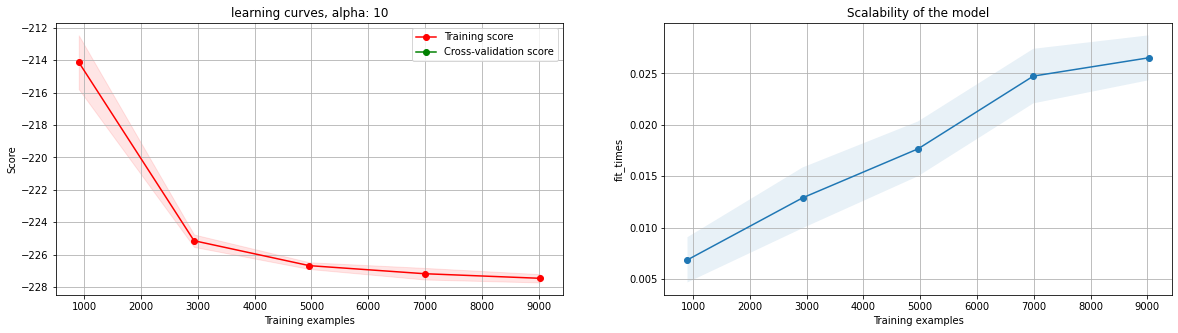

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


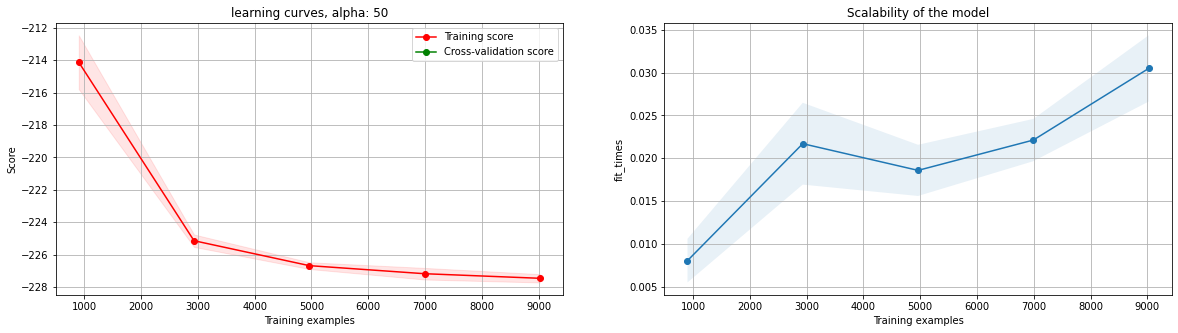

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


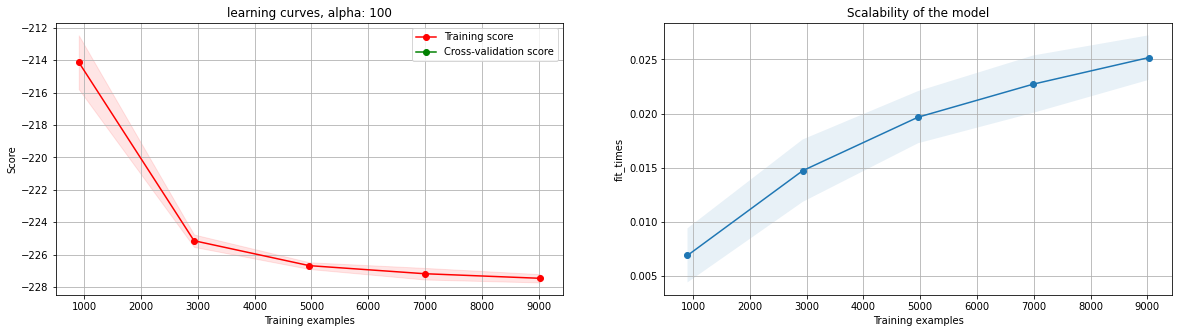

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


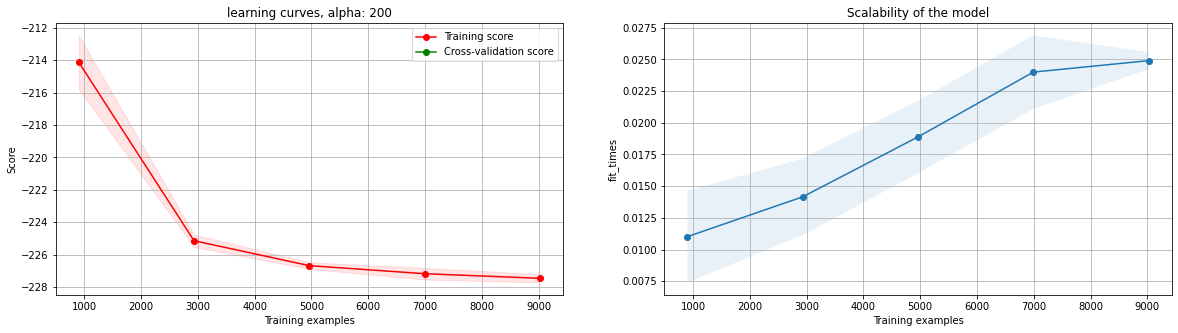

In [ ]:
for alpha in (1,10,50,100,200):
  map_ = MAP(alphas=[alpha] * 47, betas=[1, 1])
  plt = plot_learning_curve(map_, f'learning curves, alpha: {alpha}', X_train, y_train, n_jobs=-1)
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


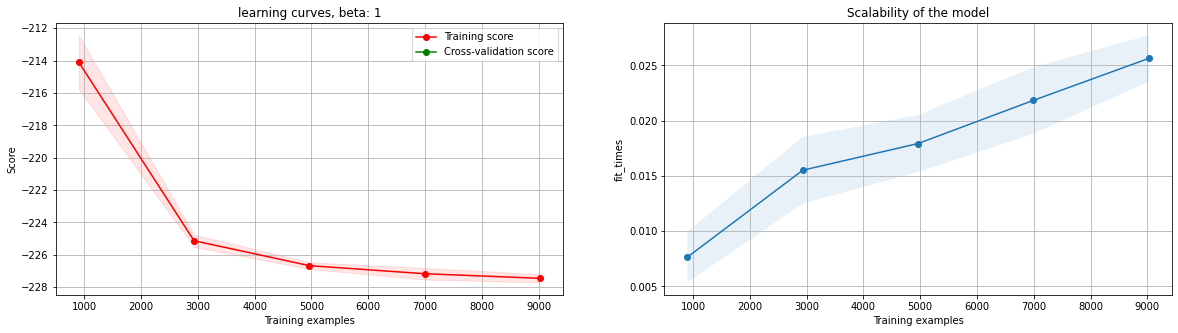

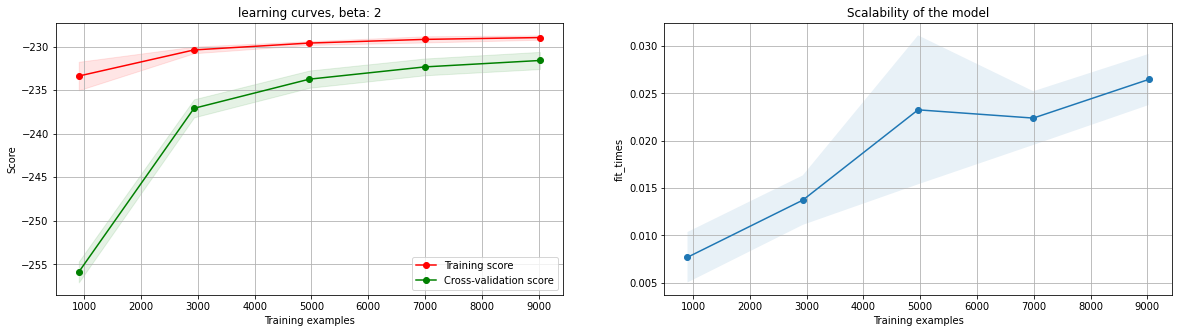

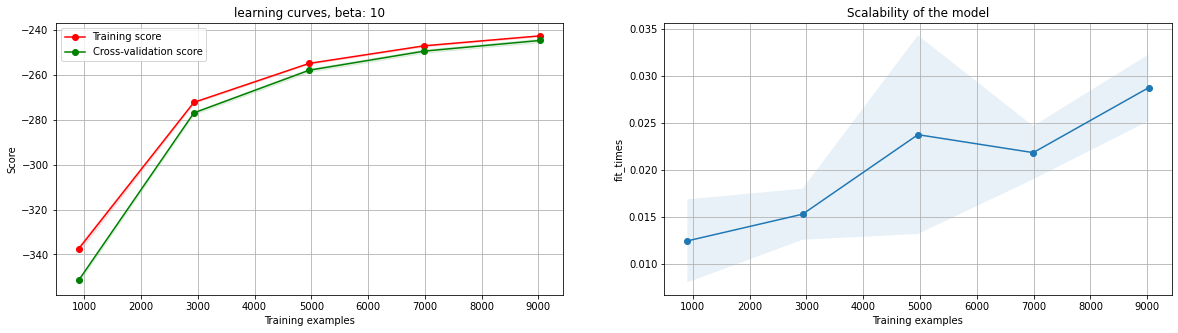

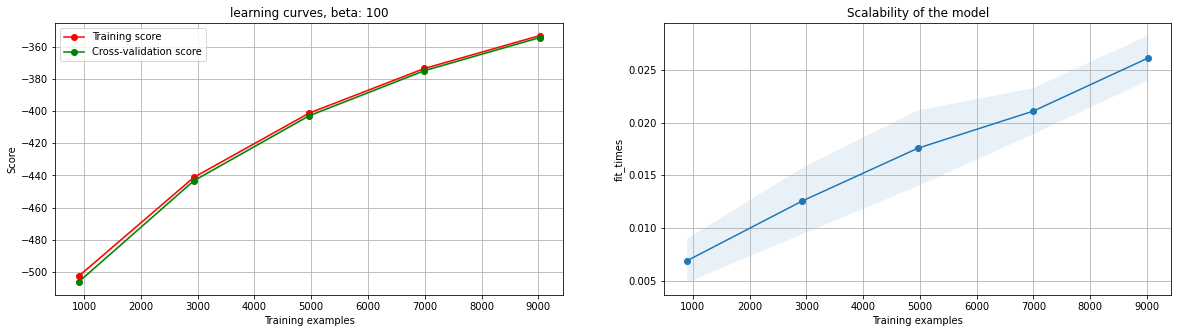

In [ ]:
for beta in (1,2,10,100):
  map_ = MAP(alphas=[1] * 47, betas=[beta, beta])
  plt = plot_learning_curve(map_, f'learning curves, beta: {beta}', X_train, y_train, n_jobs=-1)
  plt.show()

In [ ]:
proportion_1 = np.random.dirichlet([0.1]*47,1)

In [ ]:
print(proportion_1)

[[2.92055048e-03 3.51290027e-04 1.77678612e-01 1.25347722e-10
  1.23029849e-03 5.15741480e-03 5.77331109e-03 2.62983271e-01
  7.77856184e-16 1.31937672e-03 1.23357350e-03 1.95895974e-02
  1.29533246e-01 1.38265793e-06 1.71464698e-02 9.70165898e-13
  3.07119320e-04 3.28730136e-15 2.40272524e-19 1.46104731e-02
  2.14315586e-02 3.72526018e-05 3.11196142e-07 1.19215892e-03
  1.16908077e-01 2.79045490e-07 2.51635995e-05 4.35017038e-12
  5.60724017e-03 2.54003967e-10 8.19199328e-06 1.02102728e-05
  1.51273206e-02 3.84556087e-12 5.75164756e-02 2.21632517e-20
  6.28748957e-11 1.17731373e-06 4.86459781e-06 4.70229116e-02
  7.09209384e-03 2.91322896e-03 5.10459153e-02 1.86133872e-02
  1.36995463e-05 1.55924903e-02 5.10080110e-09]]


In [ ]:
dataset_size = len(X_train)
print(dataset_size)

11280


In [ ]:
import math

In [ ]:
sample_sizes=[]
for i in proportion_1[0]:
  sample_sizes.append(math.floor(i*dataset_size))

In [ ]:
print(sample_sizes)

[32, 3, 2004, 0, 13, 58, 65, 2966, 0, 14, 13, 220, 1461, 0, 193, 0, 3, 0, 0, 164, 241, 0, 0, 13, 1318, 0, 0, 0, 63, 0, 0, 0, 170, 0, 648, 0, 0, 0, 0, 530, 79, 32, 575, 209, 0, 175, 0]


In [ ]:
print(len(sample_sizes))

47


In [ ]:
for i in range(len(sample_sizes)):
  if sample_sizes[i] == 0:
    sample_sizes[i] = 1

In [ ]:
print(sample_sizes)

[32, 3, 2004, 1, 13, 58, 65, 2966, 1, 14, 13, 220, 1461, 1, 193, 1, 3, 1, 1, 164, 241, 1, 1, 13, 1318, 1, 1, 1, 63, 1, 1, 1, 170, 1, 648, 1, 1, 1, 1, 530, 79, 32, 575, 209, 1, 175, 1]


In [ ]:
X_train_unbalanced_new = []
y_train_unbalanced_new = []

In [ ]:
for i in range(len(X_train)):
  if(sample_sizes[y_train[i]]) != 0:
    sample_sizes[y_train[i]] -= 1
    X_train_unbalanced_new.append(X_train[i])
    y_train_unbalanced_new.append(y_train[i])

In [ ]:
new_X_train = np.array(X_train_unbalanced_new)

In [ ]:
new_y_train = np.array(y_train_unbalanced_new)

In [ ]:
print(new_X_train)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [ ]:
print(new_y_train)

[42 36  2 ... 42 34  2]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

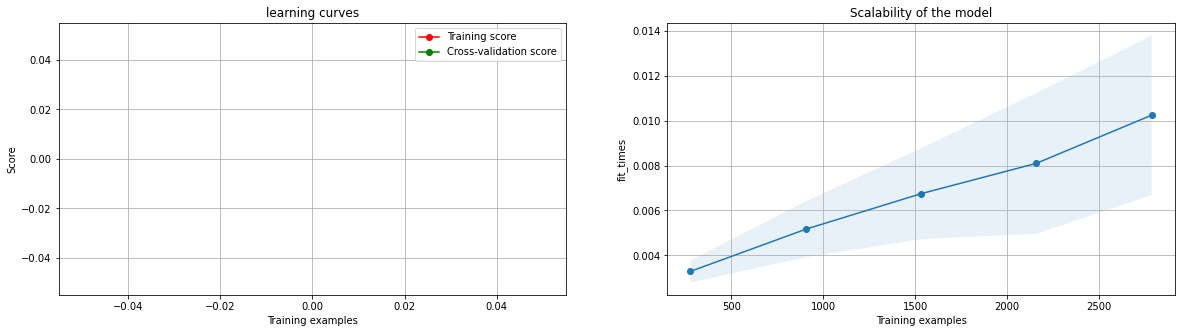

In [ ]:
mle_2 = MLE()
plot_learning_curve(MLE(), 'learning curves', new_X_train, new_y_train, n_jobs=-1)

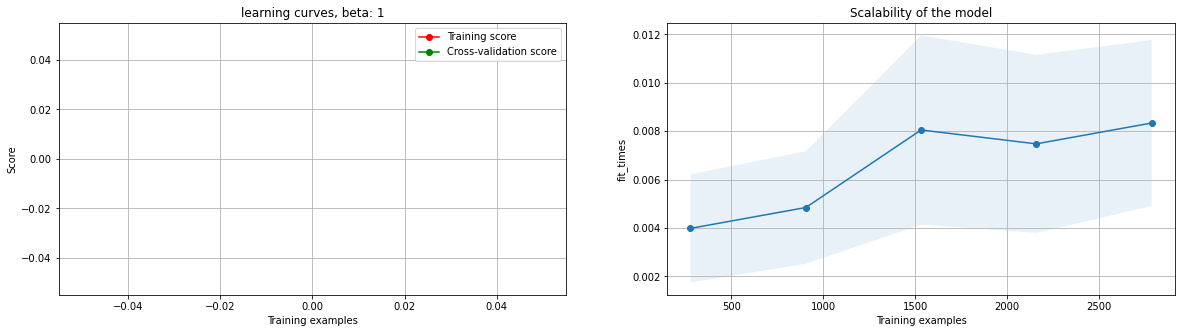

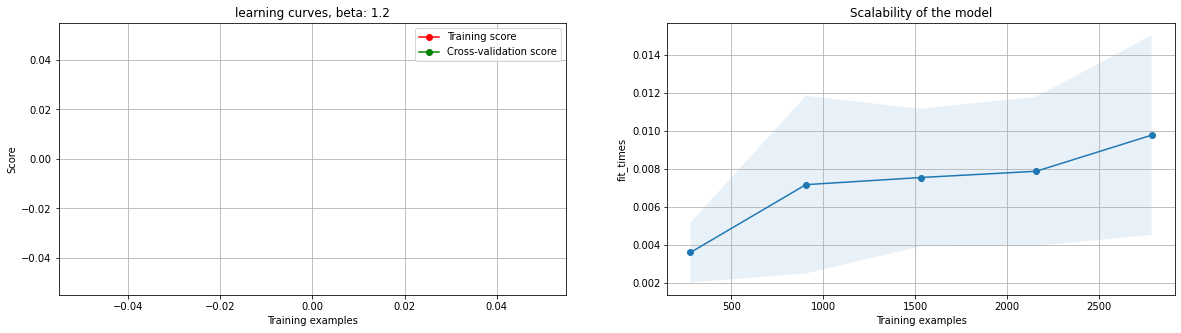

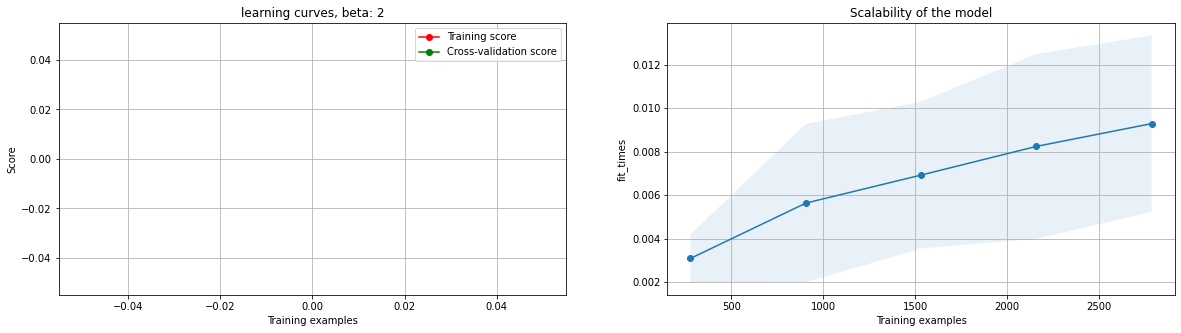

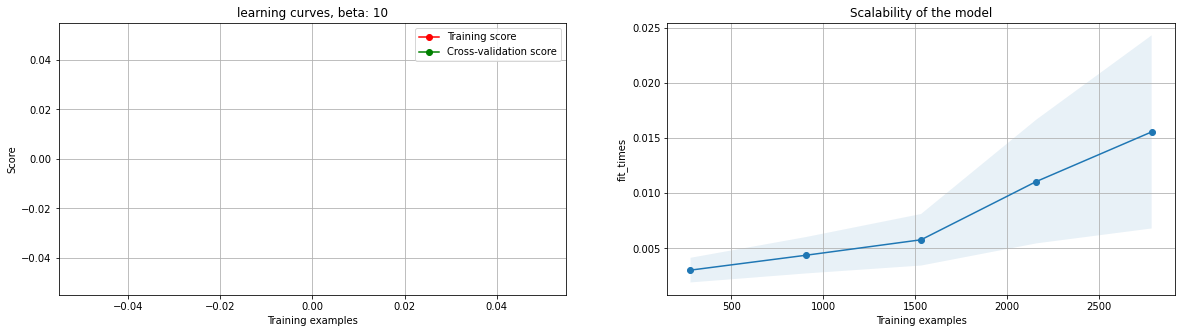

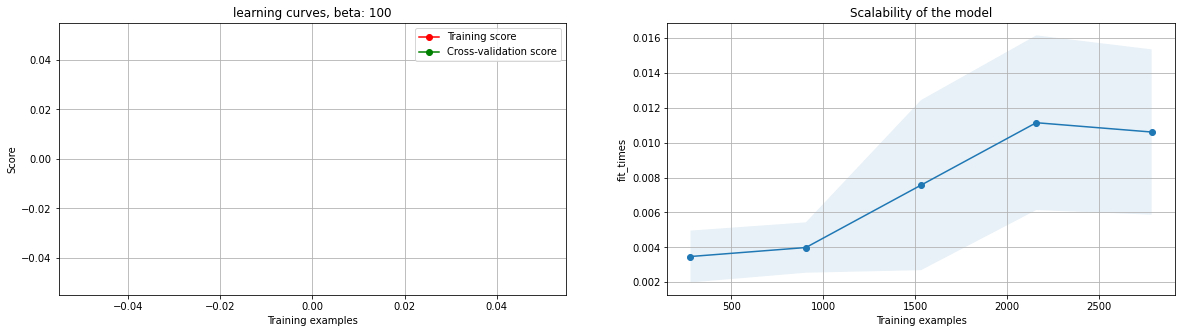

In [ ]:
for beta in (1,1.2,2,10,100):
  map_ = MAP(alphas=[1] * 47, betas=[beta, beta])
  plt = plot_learning_curve(map_, f'learning curves, beta: {beta}', new_X_train, new_y_train, n_jobs=-1)
  plt.show()

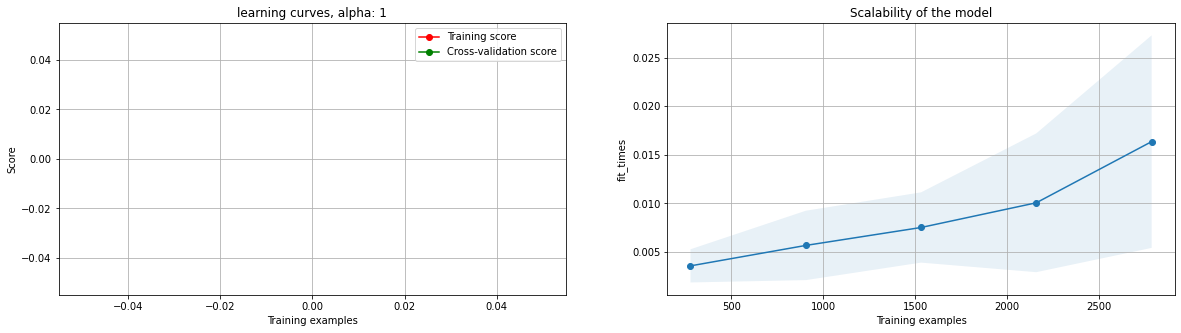

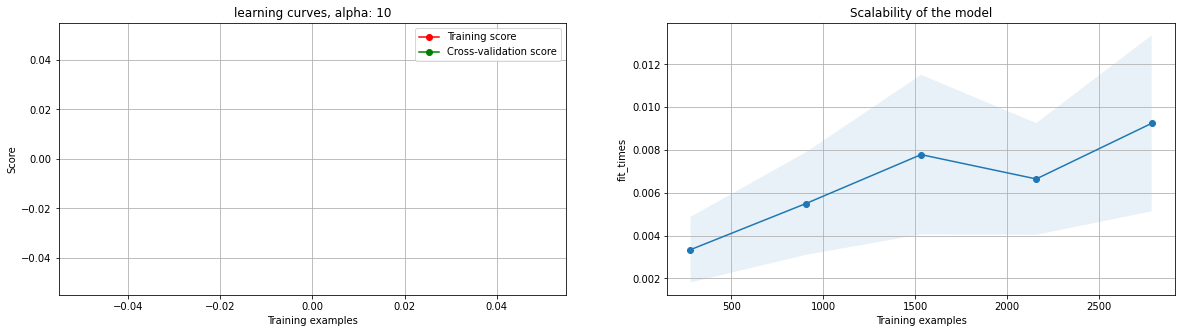

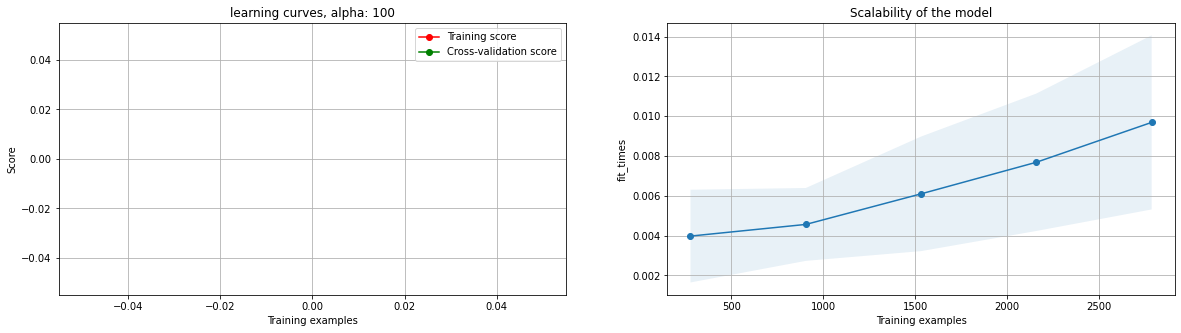

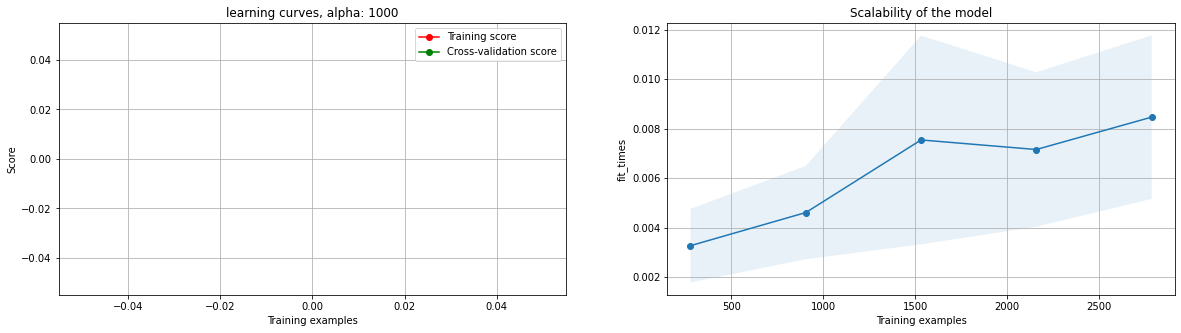

In [ ]:
for alpha in (1,10,100,1000):
  map_ = MAP(alphas=[alpha] * 47, betas=[1, 1])
  plt = plot_learning_curve(map_, f'learning curves, alpha: {alpha}', new_X_train, new_y_train, n_jobs=-1)
  plt.show()

In [ ]:
for i in (0.2,0.5,1,10,100):
  proportion = np.random.dirichlet([i]*47,1)
  print("Proportions array for alpha_class = ",i,":\n")
  print(proportion)
  sample_sizes=[]
  for j in proportion[0]:
    sample_sizes.append(math.floor(j*dataset_size))
  for j in range(len(sample_sizes)):
    if sample_sizes[j] == 0:
      sample_sizes[j] = 1
  print("Sample sizes for alpha_class = ",i,":\n")
  print(sample_sizes)
  X_train_unbalanced_new = []
  y_train_unbalanced_new = []
  for j in range(len(X_train)):
    if(sample_sizes[y_train[j]]) != 0:
      sample_sizes[y_train[j]] -= 1
      X_train_unbalanced_new.append(X_train[j])
      y_train_unbalanced_new.append(y_train[j])
  new_X_train = np.array(X_train_unbalanced_new)
  new_y_train = np.array(y_train_unbalanced_new)
  print("New X_train for alpha_class = ",i,":\n")
  print(new_X_train)
  print("New y_train for alpha_class = ",i,":\n")
  print(new_y_train)

Proportions array for alpha_class =  0.2 :

[[1.97950651e-08 4.35927854e-04 1.71986704e-03 2.41825042e-02
  1.09825788e-02 1.82508170e-02 9.20360929e-07 1.04322044e-02
  1.47574680e-02 1.17575670e-03 3.05505800e-03 2.92117156e-07
  3.60081840e-04 3.84285829e-06 6.05745813e-06 2.19643954e-03
  8.52884347e-02 1.86657845e-02 7.50587699e-04 4.62171509e-05
  2.71632385e-02 7.08984948e-08 1.69110257e-08 8.85450102e-02
  6.23108573e-02 4.18235818e-02 8.33925808e-04 6.04054424e-02
  9.52514671e-02 1.08266132e-02 5.52776201e-04 1.23332956e-11
  3.98565945e-03 2.37844295e-02 1.93842309e-03 7.90971175e-06
  6.50597312e-03 9.30449187e-06 3.81878235e-02 1.24045213e-02
  6.15076521e-03 3.63820693e-02 2.26353172e-05 2.67565647e-03
  6.49780496e-02 8.51956522e-02 1.37747267e-01]]
Sample sizes for alpha_class =  0.2 :

[1, 4, 19, 272, 123, 205, 1, 117, 166, 13, 34, 1, 4, 1, 1, 24, 962, 210, 8, 1, 306, 1, 1, 998, 702, 471, 9, 681, 1074, 122, 6, 1, 44, 268, 21, 1, 73, 1, 430, 139, 69, 410, 1, 30, 732, 96